# Exploratory analysis of combined dataset

In [112]:
from pathlib import Path

import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
# Set max number of columns to display; default 20
pd.options.display.max_columns = 50

In [3]:
# Paths to data directories
cwd_path = Path.cwd()
data_path = cwd_path.parent.joinpath('data')
data_push_path = cwd_path.parent.joinpath('data_to_push')

#### Read in data (and wrangle a bit)

In [337]:
df = pd.read_pickle(data_push_path / 'df_main_smard_era5_final_reordered.pkl')

# drop CET datetime column; no longer needed
# df.drop(columns=['datetime_cet'], inplace=True)
# move label/target to the end of the dataframe
# rearranged_columns = [col for col in df.columns if col != 'actual_generated_smard_mwh'] + ['actual_generated_smard_mwh']
# df = df[rearranged_columns]

# split off SMARD forecasted and actuals into separate dataframe and drop SMARD forecasted
df_smard_preds_vs_actuals = df.loc[:, ['forecasted_generation_smard_mwh', 'actual_generated_smard_mwh']].copy()
df.drop(columns=['forecasted_generation_smard_mwh'], inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48168 entries, 2018-01-01 00:00:00+00:00 to 2023-06-30 23:00:00+00:00
Data columns (total 32 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   hour                                            48168 non-null  int32  
 1   day_of_week                                     48168 non-null  int32  
 2   day_of_month                                    48168 non-null  int32  
 3   month_number                                    48168 non-null  int32  
 4   year                                            48168 non-null  int32  
 5   meteorological_season                           48168 non-null  object 
 6   public_holiday                                  48168 non-null  int64  
 7   turbines_in_operation                           48168 non-null  int64  
 8   total_nominal_capacity_operational_turbines_mw  48168 non-null  float

In [336]:
# The column order I want: save to pickle to persist this order
# Also, I purposely chose not to keep datetime_cet as no longer needed going forward

# desired_column_order = [
#     # Datetimeindex properties
#     'hour',
#     'day_of_week',
#     'day_of_month',
#     'month_number',
#     'year',
#     'meteorological_season',
#     # From feiertage-api.de
#     'public_holiday',
#     # Derived from wind turbines dataset
#     'turbines_in_operation',
#     'total_nominal_capacity_operational_turbines_mw',
#     # From SMARD
#     'total_nominal_capacity_smard_mw',
#     'day_ahead_price_eur_mwh',
#     'total_net_load_smard_mwh',
#     'residual_load_smard_mwh',
#     # From ERA5
#     'temp_2m_celsius',
#     'mean_sea_level_pressure_mb',
#     'wind_gusts_10m',
#     'mean_wind_speed_10m',
#     'mean_wind_speed_100m',
#     'wind_direction_angle_10m',
#     'wind_direction_angle_100m',
#     'wind_direction_intercardinal_10m',
#     'wind_direction_intercardinal_100m',
#     # Derived from ERA5 using grid weights derived from wind turbines dataset
#     'weighted_temp_2m_celsius',
#     'weighted_mean_sea_level_pressure_mb',
#     'weighted_wind_gusts_10m',
#     'weighted_mean_wind_speed_10m',
#     'weighted_mean_wind_speed_100m',
#     'weighted_mean_wind_direction_angle_10m',
#     'weighted_mean_wind_direction_angle_100m',
#     'weighted_wind_direction_intercardinal_10m',
#     'weighted_wind_direction_intercardinal_100m',
#     # SMARD day-ahead power forecast vs actuals (i.e. my label)
#     'forecasted_generation_smard_mwh',
#     'actual_generated_smard_mwh',
# ]

# df = df[desired_column_order]

# # Save to pickle
# df.to_pickle(data_push_path / 'df_main_smard_era5_final_reordered.pkl')

In [338]:
# Separate these ERA5 and ERA5-derived param groups for quicker selections later
weighted_wx_features = [
    'weighted_temp_2m_celsius',
    'weighted_mean_sea_level_pressure_mb',
    'weighted_wind_gusts_10m',
    'weighted_mean_wind_speed_10m',
    'weighted_mean_wind_speed_100m',
    'weighted_mean_wind_direction_angle_10m',
    'weighted_mean_wind_direction_angle_100m',
    'weighted_wind_direction_intercardinal_10m',
    'weighted_wind_direction_intercardinal_100m',
]

unweighted_wx_features = [
    'temp_2m_celsius',
    'mean_sea_level_pressure_mb',
    'wind_gusts_10m',
    'mean_wind_speed_10m',
    'mean_wind_speed_100m',
    'wind_direction_angle_10m',
    'wind_direction_angle_100m',
    'wind_direction_intercardinal_10m',
    'wind_direction_intercardinal_100m',
]

# Create separate dataframes as well
df_weighted = df.loc[:, ~df.columns.isin(unweighted_wx_features)].copy()
df_unweighted = df.loc[:, ~df.columns.isin(weighted_wx_features)].copy()

In [339]:
df.isna().sum()

hour                                                 0
day_of_week                                          0
day_of_month                                         0
month_number                                         0
year                                                 0
meteorological_season                                0
public_holiday                                       0
turbines_in_operation                                0
total_nominal_capacity_operational_turbines_mw       0
total_nominal_capacity_smard_mw                      0
day_ahead_price_eur_mwh                           6550
total_net_load_smard_mwh                             0
residual_load_smard_mwh                              0
temp_2m_celsius                                      0
mean_sea_level_pressure_mb                           0
wind_gusts_10m                                       0
mean_wind_speed_10m                                  0
mean_wind_speed_100m                                 0
wind_direc

In [340]:
df.describe()

,hour,day_of_week,day_of_month,month_number,year,public_holiday,turbines_in_operation,total_nominal_capacity_operational_turbines_mw,total_nominal_capacity_smard_mw,day_ahead_price_eur_mwh,total_net_load_smard_mwh,residual_load_smard_mwh,temp_2m_celsius,mean_sea_level_pressure_mb,wind_gusts_10m,mean_wind_speed_10m,mean_wind_speed_100m,wind_direction_angle_10m,wind_direction_angle_100m,weighted_temp_2m_celsius,weighted_mean_sea_level_pressure_mb,weighted_wind_gusts_10m,weighted_mean_wind_speed_10m,weighted_mean_wind_speed_100m,weighted_mean_wind_direction_angle_10m,weighted_mean_wind_direction_angle_100m,actual_generated_smard_mwh
count,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,41618.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000
mean,11.500000,2.997509,15.716492,6.251619,2020.270553,0.002429,28625.879422,54216.183891,53849.704638,97.951645,56219.703579,36924.776340,10.216761,1016.364811,6.945310,3.403946,5.747104,191.878098,194.632889,10.357187,1015.912618,7.247443,3.642511,6.125059,195.617986,198.109288,11193.426461
std,6.922258,1.999396,8.793736,3.439449,1.599109,0.049225,462.136710,2355.850195,1700.822139,107.700848,9832.762332,12559.928192,7.485719,9.026248,2.917239,1.373546,2.210253,64.455742,65.061592,7.343503,9.431296,3.079814,1.496988,2.373912,67.100808,67.589109,8992.759097
min,0.000000,0.000000,1.000000,1.000000,2018.000000,0.000000,27464.000000,49732.097897,51633.000000,-129.960000,30909.000000,-5370.500000,-12.340430,972.342813,1.910964,0.819818,1.150553,22.478209,21.372946,-12.353219,971.750173,1.816411,0.860357,1.186652,18.788045,19.789689,100.250000
25%,5.750000,1.000000,8.000000,3.000000,2019.000000,0.000000,28304.000000,52353.193417,52792.000000,35.050000,48175.687500,28525.562500,4.303812,1011.134180,4.782694,2.391495,4.161518,146.448418,148.723846,4.642113,1010.345478,4.962623,2.527088,4.397004,147.137573,148.870189,4245.875000
50%,11.500000,3.000000,16.000000,6.000000,2020.000000,0.000000,28664.000000,53790.932467,53184.000000,53.920000,56035.250000,37295.125000,9.597971,1016.906797,6.369528,3.090817,5.346018,200.376053,204.613251,9.776790,1016.555933,6.645048,3.320524,5.722192,207.578807,211.532572,8473.000000
75%,17.250000,5.000000,23.000000,9.000000,2022.000000,0.000000,28982.000000,56033.684347,55289.000000,119.802500,64212.000000,45628.437500,15.746774,1022.105957,8.502666,4.094744,6.930403,242.063076,245.364609,15.714599,1022.037480,8.909549,4.424359,7.448320,247.089817,249.770198,15918.500000
max,23.000000,6.000000,31.000000,12.000000,2023.000000,1.000000,29418.000000,59315.041337,57590.000000,871.000000,81077.500000,74313.250000,33.672296,1041.468125,23.699093,11.017428,17.585875,335.886993,338.821259,33.866775,1041.719498,25.159453,12.178314,19.184025,339.868895,341.861569,45285.250000


-----

### Just had an idea: Add German public holidays data to dataset as an additional feature/predictor!

#### Fetch German public holiday dates from free API service (thanks, guys! 👍🏻)
- Link: https://feiertage-api.de
- 117 public holidays during my chosen time period

In [7]:
# years = [2018, 2019, 2020, 2021, 2022, 2023]
# list_of_datadicts = []

# for year in years:
#     url_endpoint = f'https://feiertage-api.de/api/?jahr={year}&nur_daten'
#     response = requests.get(url_endpoint)

#     if response.status_code == 200:  
#             # Decode JSON response object to Python dict
#             list_of_datadicts.append(response.json())
#     else:
#         print(f'Request failed with status code: {response.status_code}')
        
# len(list_of_datadicts)

6

In [29]:
# df_public_holidays = pd.DataFrame(list_of_datadicts)

# # Map all dates to datetime timestamps localise to UTC (since only day alignment is needed, not hourly)
# df_public_holidays = df_public_holidays.map(lambda date: pd.to_datetime(date, yearfirst=True, utc=True))

# # Flatten the dataframe to 1D array of Timestamps!
# public_holiday_timestamps = df_public_holidays.to_numpy().flatten()

# # Creat new column by putting bool array as condition inside np.where and replacing bool with 0s & 1s
# df['public_holiday'] = np.where(df.index.isin(public_holiday_timestamps), 1, 0)

In [37]:
# df['public_holiday'].sum()

117

#### Save to pickle

In [38]:
# df.to_pickle(data_push_path / 'df_main_smard_era5_final.pkl')

-----

-----

## Check for linear correlations between features and label

In [345]:
def plot_correlation_heatmap(df):
    # Get the correlation matrix as a dataframe
    corr = df.corr(numeric_only=True)

    # Create mask to remove redundant half
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Abbreviate column names; select only numeric columns in df!
    abbreviated_column_names = [col[:40] + '...' if len(col) > 40 else col for col in df.select_dtypes('number').columns]
    
    # A couple of divergent colour palettes to see what works best
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    # cmap = sns.color_palette("coolwarm", as_cmap=True)
    
    sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={'shrink': .2}, annot=True, fmt='.2f', annot_kws={'size': 6},
                xticklabels=abbreviated_column_names, yticklabels=abbreviated_column_names)
    
    # Rotate x labels for readability
    ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right', fontsize=7)
    
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=7)
    # Set the target name in bold
    y_labels = ax.get_yticklabels()
    y_labels[-1].set_weight('bold')
    
    # plt.tight_layout()
    plt.show()

#### Using `df_unweighted`

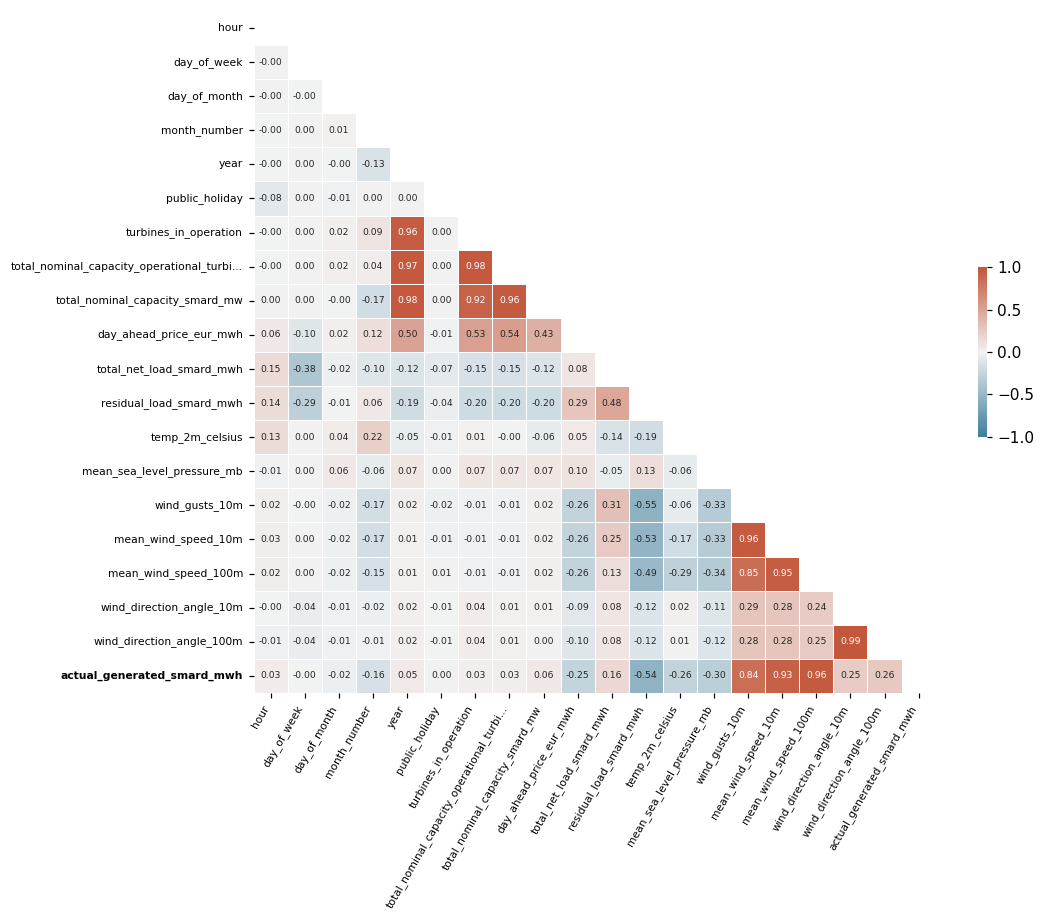

In [346]:
plot_correlation_heatmap(df_unweighted)

#### Using `df_weighted`: Stronger linear correlations between label and weighted wind features!
- Especially 100m wind, 10m gusts, and msl

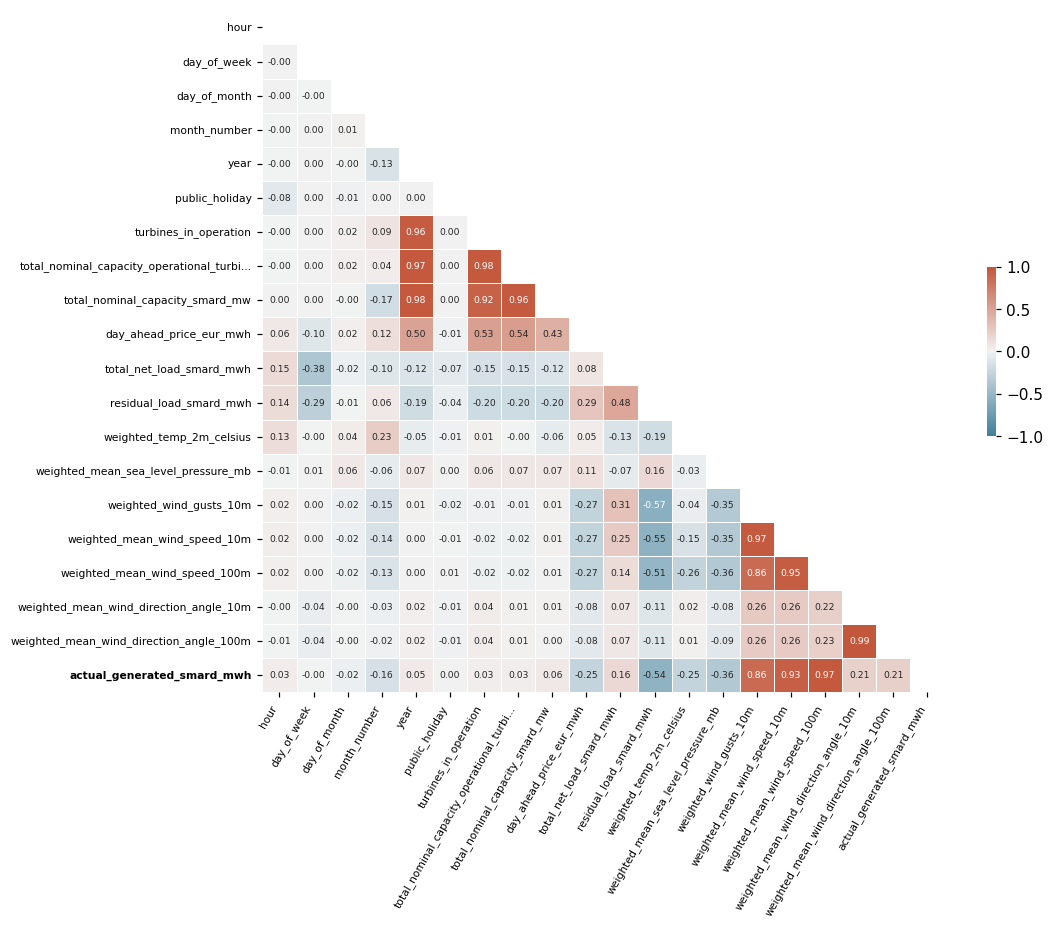

In [347]:
plot_correlation_heatmap(df_weighted)

----

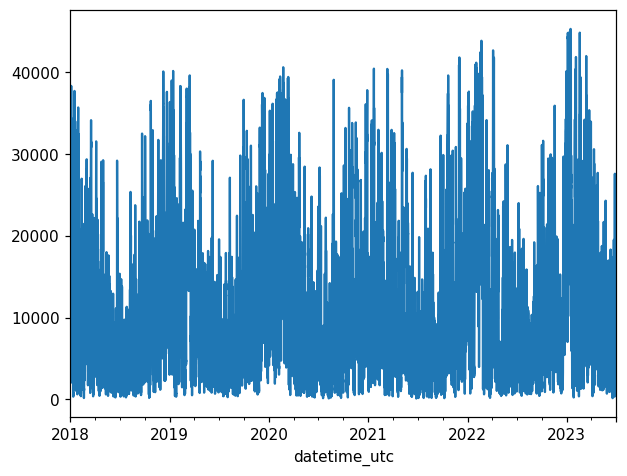

In [69]:
df['actual_generated_smard_mwh'].plot();

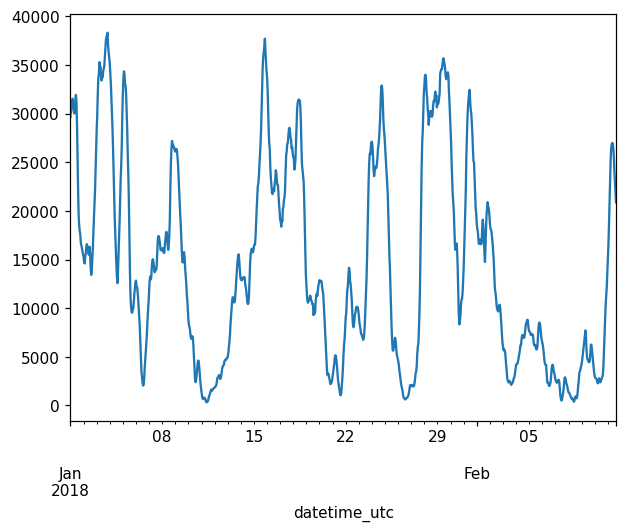

In [68]:
df['actual_generated_smard_mwh'].iloc[0:1_000].plot();

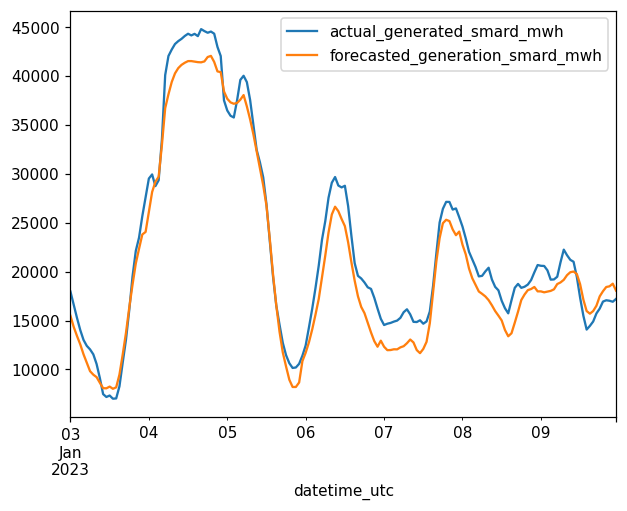

In [344]:
# SMARD actual vs SMARD forecasted
df_smard_preds_vs_actuals.loc['2023-01-03': '2023-01-09'].plot(kind='line', y=['actual_generated_smard_mwh', 'forecasted_generation_smard_mwh']);

In [81]:
# filter on just one day
# df.loc['2023-01-01']

-----

### Plot a seasonal decomposition plot
- Use statsmodels' `seasonal_decompose`
    - https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html

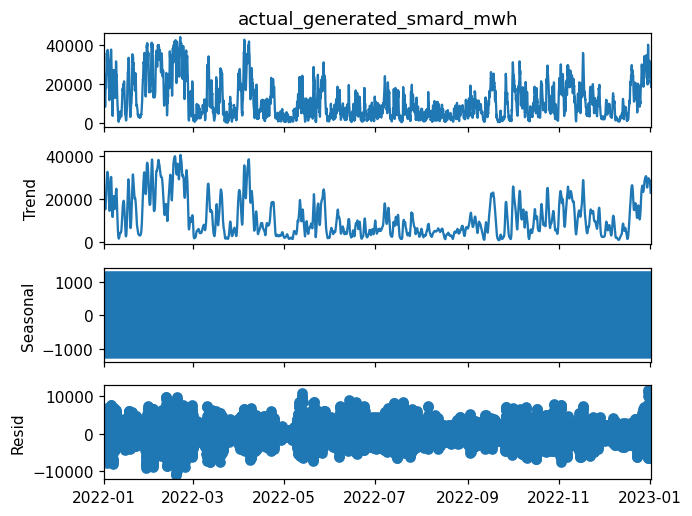

In [110]:
decomposed_result = seasonal_decompose(df.loc['2022-01-01':'2023-01-01', 'actual_generated_smard_mwh'], model='additive')
decomposed_result.plot()
plt.show()